<a href="https://colab.research.google.com/github/awill139/Demystifying-AI-Course/blob/master/Copy_of_Fundamentals_of_AI_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

#https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
import seaborn as sns
from scipy import stats
from google.colab import files
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
np.random.seed(42)

We need to start by getting our data from the github. We will save it in a pandas dataframe. For those unaquainted with this format, imagine an excel sheet where we can manipulate our data as we want

In [0]:

# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
url = 'https://raw.githubusercontent.com/princetonschoolofai/Fundamentals_of_AI/master/housing_train.csv'
train = pd.read_csv(url)
url2 = 'https://raw.githubusercontent.com/princetonschoolofai/Fundamentals_of_AI/master/housing_test.csv'
test = pd.read_csv(url2)

Let's take a looksie

The train and test look the same, just have different values

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We need to start by understanding our data and cleaning it. For example, we as humans know that the ID field will not help a model, so we will drop it, as well as fill in missing values so our model will be able to understand it

As a disclaimer, the cleaning and visualization of the data was not written by me. I will do my best to explain it but it was taken from

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

I suggest looking there to get a better understanding of the data as well as the author's insight as to why he did what he did. I don't want to spend too much time on this because this is a class in machine learning, but the cleaning and understanding of the data is arguably more important than the cool ML part. One of the first things a computer science professor will tell you is 'Garbage in, garbage out'

In [4]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


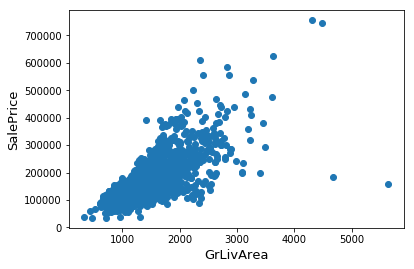

In [5]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


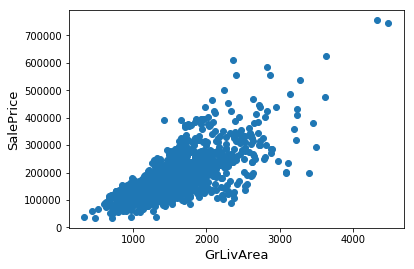

In [6]:
#Delete the outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



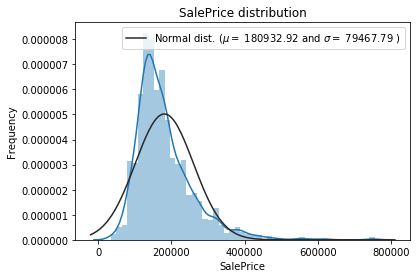

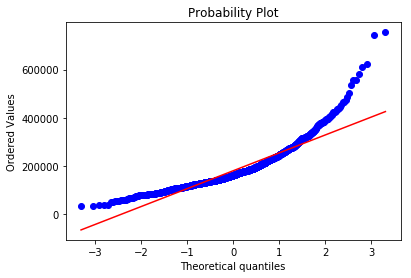

In [7]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 180932.92 and sigma = 79467.79



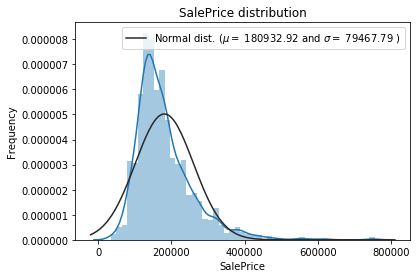

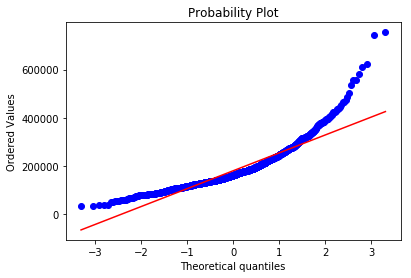

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

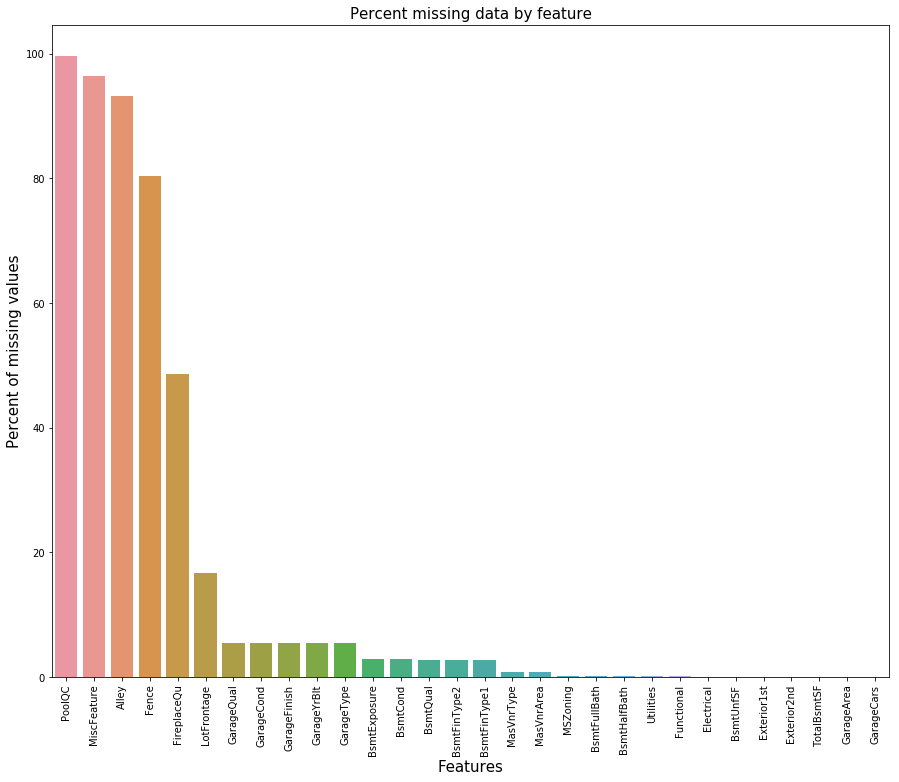

In [11]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

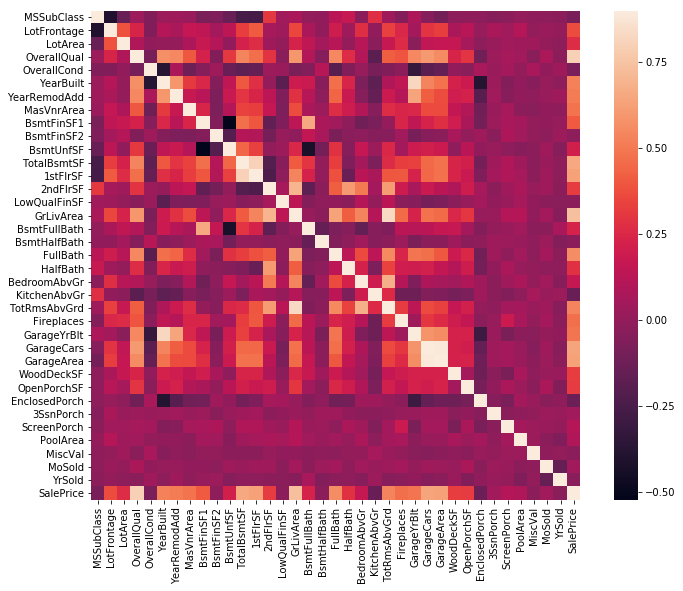

In [12]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [13]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [0]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [15]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [0]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [17]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [18]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


In [19]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [21]:
y_train

array([208500, 181500, 223500, ..., 266500, 142125, 147500])

In [22]:
x = train.as_matrix().astype(np.float32).T
yuse = np.asmatrix(y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
y = yuse / 1000000.0

In [24]:
yuse

matrix([[208500, 181500, 223500, ..., 266500, 142125, 147500]])

##Wow. Now we get to use this data
This will probably all seem very similar to what we did before, I did my best to make it so. The idea is that we want to do this, just on a larger scale

Let's start by defining some activation functions and their derrivatives



In [0]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    d = dA > 0
    return Z * d
  
def tanh_backward(Z):
    return (1 - np.power(Z, 2))

This part will be a little different. In defining our weights, we just had 1 hidden layer before and we could control the number of neurons with the 'hidden' variable. There are ways to make the following more scalable, but I thought this way would help see how everything is behaving together. When declaring the weights, it should be thought of as (output, input) so in W1 for example, we have the number of our inputs (x_n) in the second place and our number of outputs in the first

In [0]:
def parameter_init(x_n, y_n):
  W1 = np.random.randn(32, x_n) * 0.01
  b1 = np.zeros(shape=(32, 1))
  W2 = np.random.randn(64, 32) * 0.01
  b2 = np.zeros(shape=(64, 1))
  W3 = np.random.randn(128, 64) * 0.01
  b3 = np.zeros(shape=(128, 1))
  W4 = np.random.randn(512, 128) * 0.01
  b4 = np.zeros(shape=(512, 1))
  W5 = np.random.randn(1, 512) * 0.01
  b5 = np.zeros(shape=(1, 1))
  
  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3,
                "W4": W4,
                "b4": b4,
                "W5": W5,
                "b5": b5}
  
  return parameters

In [0]:
def forward(x, params):
  W1 = params['W1']
  b1 = params['b1']
  W2 = params['W2']
  b2 = params['b2']
  W3 = params['W3']
  b3 = params['b3']
  W4 = params['W4']
  b4 = params['b4']
  W5 = params['W5']
  b5 = params['b5']


  Z1 = np.dot(W1, x) + b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2,A1) + b2
  A2 = np.tanh(Z2)
  Z3 = np.dot(W3, A2) + b3
  A3 = np.tanh(Z3)
  Z4 = np.dot(W4,A3) + b4
  A4 = np.tanh(Z4)
  #print(A4.shape)
  #print(W5.shape)
  Z5 = np.dot(W5, A4) + b5
  #print(Z5.shape)
  Z5 = np.sum(Z5, axis = 0)
  #print(Z5.shape)
  try:
    Z5 = np.reshape(Z5, [1, Z5.shape[0]])
  except:
    pass
  #print(Z5.shape)
  
  A5 = sigmoid(Z5)
  #print(A5.shape)
  
  cache = {"Z1": Z1,
           "A1": A1,
           "Z2": Z2,
           "A2": A2,
           "Z3": Z3,
           "A3": A3,
           "Z4": Z4,
           "A4": A4,
           "Z5": Z5,
           "A5": A5}

  return A5, cache

In [0]:
def compute_cost(A5, y, params):
  n = y.shape[0]

  logprob = np.multiply(np.log(A5), y) + np.multiply(np.log(1 - A5), 1 - y)
  cost = -np.sum(logprob) / n
  
  cost = np.squeeze(cost) # Remove single-dimensional entries from the shape of an array.
  
  return cost

In [0]:
def backward(params, cache, x, y):
  n = x.shape[1]
  
  W1 = params['W1']
  W2 = params['W2']
  W3 = params['W3']
  W4 = params['W4']
  W5 = params['W5']
  
  A1 = cache['A1']
  A2 = cache['A2']
  A3 = cache['A3']
  A4 = cache['A4']
  A5 = cache['A5']
  
  
  dZ5 = A5 - y
  #print(A5.shape)
  #print(y.shape)
  dW5 = (1 / n) * np.dot(dZ5, A4.T)
  db5 = (1 /  n) * np.sum(dZ5, axis = 1)
  dZ4 = np.multiply(np.dot(W5.T, dZ5), tanh_backward(A4))
  dW4 = (1 / n) * np.dot(dZ4, A3.T)
  db4 = (1 / n) * np.sum(dZ4, axis = 1)
  dZ3 = np.multiply(np.dot(W4.T, dZ4), tanh_backward(A3))
  dW3 = (1 / n) * np.dot(dZ3, A2.T)
  db3 = (1 / n) * np.sum(dZ3, axis = 1)
  dZ2 = np.multiply(np.dot(W3.T, dZ3), tanh_backward(A2))
  dW2 = (1 / n) * np.dot(dZ2, A1.T)
  db2 = (1 / n) * np.sum(dZ2, axis=1)
  dZ1 = np.multiply(np.dot(W2.T, dZ2), tanh_backward(A1))
  dW1 = (1 / n) * np.dot(dZ1, x.T)
  db1 = (1 / n) * np.sum(dZ1, axis=1)
  
  grads = {"dW1": dW1,
           "db1": db1,
           "dW2": dW2,
           "db2": db2,
           "dW3": dW3,
           "db3": db3,
           "dW4": dW4,
           "db4": db4,
           "dW5": dW5,
           "db5": db5}

  return grads

This is where we will update our parameters

In [0]:
def update_params(params, grads, lr):
  W1 = params['W1']
  b1 = params['b1']
  W2 = params['W2']
  b2 = params['b2']
  W3 = params['W3']
  b3 = params['b3']
  W4 = params['W4']
  b4 = params['b4']
  W5 = params['W5']
  b5 = params['b5']

  dW1 = grads['dW1']
  db1 = grads['db1']
  dW2 = grads['dW2']
  db2 = grads['db2']
  dW3 = grads['dW3']
  db3 = grads['db3']
  dW4 = grads['dW4']
  db4 = grads['db4']
  dW5 = grads['dW5']
  db5 = grads['db5']


  W1 = W1 - lr * dW1
  b1 = b1 - lr * db1
  W2 = W2 - lr * dW2
  b2 = b2 - lr * db2
  W3 = W3 - lr * dW3
  b3 = b3 - lr * db3
  W4 = W4 - lr * dW4
  b4 = b4 - lr * db4
  W5 = W5 - lr * dW5
  b5 = b5 - lr * db5


  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3,
                "W4": W4,
                "b4": b4,
                "W5": W5,
                "b5": b5}

  return parameters

And now putting it all together in a model. The print_cost just says if we want to print the cost on each 1000th iteration

In [0]:
def cool_model(x, y, iters, print_cost):
  x_n = x.shape[0]
  y_n = y.shape[0]


  params = parameter_init(x_n, y_n)
  
  for i in range(iters):
    A5, cache = forward(x, params)
    #print(A5.shape)
    try:
      A5 = np.reshape(A5, [1, A5.shape[0]])
    except:
      pass
    
    cost = np.sqrt(mean_squared_error((y*1000000.0), (A5*1000000)))#compute_cost(A5, y, params)
    
    grads = backward(params, cache, x, y)
    params = update_params(params, grads, lr = .5)
    
    if print_cost and i % 1000 == 0:
      print('Cost after iteration {}: {}'.format(i, cost))
      
  return params
  

In [0]:
def predict(params, x):
  A5, cache = forward(x, params)
  #print(A2)
  pred = A5 * 1000000.0
  return pred

In [33]:
params = cool_model(x = x, y = y, iters = 10001, print_cost = True)

Cost after iteration 0: 328815.30346626666
Cost after iteration 1000: 79430.53715384741
Cost after iteration 2000: 47504.930648433394
Cost after iteration 3000: 34288.304704736365
Cost after iteration 4000: 29982.779361122106
Cost after iteration 5000: 27431.109058003494
Cost after iteration 6000: 25387.52320123833
Cost after iteration 7000: 23894.571117670395
Cost after iteration 8000: 22735.507021516187
Cost after iteration 9000: 21751.930593732402
Cost after iteration 10000: 20866.533928308283


In [0]:
q = predict(params, x)

In [35]:
q.shape

(1, 1458)

In [0]:
preds = predict(params, x)
#print ('Accuracy: {}%'.format(float((np.dot(y, preds.T) + np.dot(1-y,1-preds.T))/float(y.size)*100))) 

In [37]:
q

matrix([[194709.25932563, 157287.13545126, 214646.14849008, ...,
         224460.92245119, 120757.66912321, 144255.91875256]])

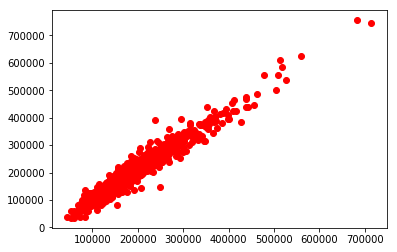

In [38]:
plt.plot(q, yuse, 'ro')
plt.show()